In [1]:
# Environment
import numpy as np

ACTIONS = {'U': (-1, 0), 'D': (1, 0), 'L': (0, -1), 'R': (0, 1)}

class Maze(object):
    def __init__(self):
        self.maze = np.zeros((6, 6))
        self.maze[0, 0] = 2
        self.maze[5, :5] = 1
        self.maze[:4, 5] = 1
        self.maze[2, 2:] = 1
        self.maze[3, 2] = 1
        self.robot_position = (0, 0)
        self.steps = 0
        self.construct_allowed_states()

    def print_maze(self):
        print('---------------------------------')
        for row in self.maze:
            for col in row:
                if col == 0:
                    print('', end="\t") # empty space
                elif col == 1:
                    print('X', end="\t") # walls
                elif col == 2:
                    print('R', end="\t") # robot position
            print("\n")
        print('---------------------------------')

    def is_allowed_move(self, state, action):
        # check allowed move from a given state
        y, x = state
        y += ACTIONS[action][0]
        x += ACTIONS[action][1]
        if y < 0 or x < 0 or y > 5 or x > 5:
            # if robot will move off the board
            return False

        if self.maze[y, x] == 0 or self.maze[y, x] == 2:
            # if robot moves into empty space or its original start position
            return True
        else:
            return False

    def construct_allowed_states(self):
        # create a dictionary of allowed states from any position
        # using the isAllowedMove() function
        # this is so that you don't have to call the function every time
        allowed_states = {}
        for y, row in enumerate(self.maze):
            for x, col in enumerate(row):
                # iterate through all spaces
                if self.maze[(y,x)] != 1:
                    # if the space is not a wall, add it to the allowed states dictionary
                    allowed_states[(y,x)] = []
                    for action in ACTIONS:
                        if self.is_allowed_move((y,x), action) & (action != 0):
                            allowed_states[(y,x)].append(action)
        self.allowed_states = allowed_states

    def update_maze(self, action):
        y, x = self.robot_position # get current position
        self.maze[y, x] = 0 # set the current position to 0
        y += ACTIONS[action][0] # get new position
        x += ACTIONS[action][1] # get new position
        self.robot_position = (y, x) # set new position
        self.maze[y, x] = 2 # set new position
        self.steps += 1 # add steps

    def is_game_over(self):
        # check if robot in the final position
        if self.robot_position == (5, 5):
            return True
        else:
            return False

    def get_state_and_reward(self):
        return self.robot_position, self.give_reward()

    def give_reward(self):
        # if at end give 0 reward
        # if not at end give -1 reward
        if self.robot_position == (5, 5):
            return 0
        else: 
            return -1

In [2]:
# Agent

import numpy as np

ACTIONS = {'U': (-1, 0), 'D': (1, 0), 'L': (0, -1), 'R': (0, 1)}

class Agent(object):
    def __init__(self, states, alpha=0.15, random_factor=0.2): # 80% explore, 20% exploit
        self.state_history = [((0, 0), 0)] # state, reward
        self.alpha = alpha
        self.random_factor = random_factor
        self.G = {}
        self.init_reward(states)

    def init_reward(self, states):
        for i, row in enumerate(states):
            for j, col in enumerate(row):
                self.G[(j, i)] = np.random.uniform(low=1.0, high=0.1)
    
    def choose_action(self, state, allowedMoves):
        maxG = -10e15
        next_move = None
        randomN = np.random.random()
        if randomN < self.random_factor:
            # if random number below random factor, choose random action
            next_move = np.random.choice(allowedMoves)
        else:
            # if exploiting, gather all possible actions and choose one with the highest G (reward)
            for action in allowedMoves:
                new_state = tuple([sum(x) for x in zip(state, ACTIONS[action])])
                if self.G[new_state] >= maxG:
                    next_move = action
                    maxG = self.G[new_state]

        return next_move

    def update_state_history(self, state, reward):
        self.state_history.append((state, reward))

    def learn(self):
        target = 0

        for prev, reward in reversed(self.state_history):
            self.G[prev] = self.G[prev] + self.alpha * (target - self.G[prev])
            target += reward

        self.state_history = []

        self.random_factor -= 10e-5 # decrease random factor each episode of play

0
1000
2000
3000
4000


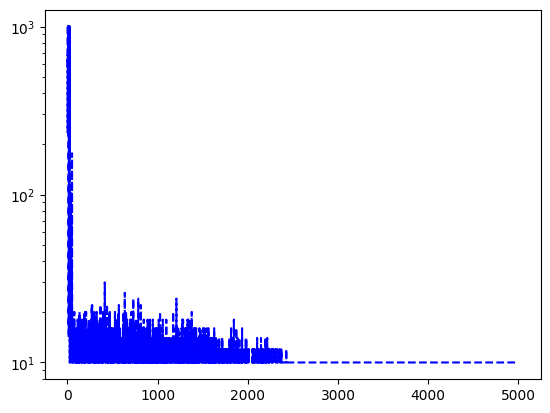

In [3]:
# main
import numpy as np
# from environment import Maze
# from agent import Agent
import matplotlib.pyplot as plt

if __name__ == '__main__':
    maze = Maze()
    robot = Agent(maze.maze, alpha=0.1, random_factor=0.25)
    moveHistory = []

    for i in range(5000):
        if i % 1000 == 0:
            print(i)

        while not maze.is_game_over():
            state, _ = maze.get_state_and_reward() # get the current state
            action = robot.choose_action(state, maze.allowed_states[state]) # choose an action (explore or exploit)
            maze.update_maze(action) # update the maze according to the action
            state, reward = maze.get_state_and_reward() # get the new state and reward
            robot.update_state_history(state, reward) # update the robot memory with state and reward
            if maze.steps > 1000:
                # end the robot if it takes too long to find the goal
                maze.robot_position = (5, 5)
        
        robot.learn() # robot should learn after every episode
        moveHistory.append(maze.steps) # get a history of number of steps taken to plot later
        maze = Maze() # reinitialize the maze

plt.semilogy(moveHistory, "b--")
plt.show()